# Exploratory Data Analysis

In this notebook we will be looking at the Acquire Valued Shoppers Dataset. This dataset has 350 million transactions for more than 300k customers. The transactions are available at the basket-level, so each row is a single product that was bought by a given customer.

The detailed description is available at [kaggle](https://www.kaggle.com/c/acquire-valued-shoppers-challenge/data). Note that this dataset was used for another purpose (business problem) during the original kaggle competition.


### Summary

For this first exploration we will be using a random sample with 10,000 customers.

The notebook has five sections:


##### 1. Reading and joining data

##### 2. Transactions overview and missing values

##### 3. Univariate analysis

##### 4. Timeseries analysis

##### 5. Customer-aggregated analysis

# 1. Reading and joining data

In [1]:
!python -m pip install --upgrade --quiet pandas

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [8]:
import io
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import boto3

def read_from_s3(bucket, filepath):
    buffer = io.BytesIO()
    s3 = boto3.resource('s3')
    obj = s3.Object(bucket, filepath)
    obj.download_fileobj(buffer)
    return pd.read_parquet(buffer)

In [9]:
# Read transactions file sample from S3
bucket = 'capstone-transaction-data'
df = read_from_s3(bucket, 'raw_data/transactions_sample.parquet', 'parquet')
display(df)

,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,16802992,18,97,9753,10000,0,20120309,1.0,CT,1,0.00
1,16802992,18,99,9908,102113020,15704,20120309,6.0,OZ,1,2.00
2,16802992,18,99,9908,102113020,15704,20120309,8.0,OZ,1,2.00
3,16802992,18,58,5827,107024777,6176,20120316,16.0,OZ,1,5.99
4,16802992,18,73,7304,104110040,4082,20120323,20.0,CT,1,6.29
...,...,...,...,...,...,...,...,...,...,...,...
10183362,4809346917,284,41,4105,104130343,38922,20130621,14.5,OZ,2,2.00
10183363,4809346917,284,56,5613,104130343,38922,20130621,32.0,OZ,1,6.99
10183364,4809346917,284,41,4120,104130343,38922,20130621,6.0,OZ,2,1.38
10183365,4809346917,284,58,5831,103927232,26234,20130621,20.0,OZ,2,7.00


# 2. Transactions overview and missing values

The transactions table is our main source of information to build our LTR model. Therefore, sections 2, 3 and 4 will be dedicted to understand this table in detail. Section 2 is a quick overview of the dataset.

In [5]:
df.describe()

,id,chain,dept,category,company,brand,date,productsize,purchasequantity,purchaseamount
count,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07,1.018337e+07
mean,1.853505e+09,1.258982e+02,4.070265e+01,4.084304e+03,2.666250e+08,1.730619e+04,2.012382e+07,2.711632e+01,1.504077e+00,4.032407e+00
std,1.536070e+09,1.265067e+02,2.835619e+01,2.839233e+03,5.698878e+08,1.881225e+04,4.442766e+03,5.006006e+01,3.467287e+01,6.460920e+00
min,1.680299e+07,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,0.000000e+00,2.012030e+07,0.000000e+00,-2.600000e+02,-7.950100e+02
25%,5.007586e+08,2.100000e+01,1.700000e+01,1.703000e+03,1.024100e+08,6.947000e+03,2.012063e+07,6.700000e+00,1.000000e+00,1.990000e+00
50%,7.656634e+08,9.600000e+01,3.600000e+01,3.611000e+03,1.041409e+08,1.212900e+04,2.012102e+07,1.325000e+01,1.000000e+00,3.000000e+00
75%,3.273041e+09,1.650000e+02,5.800000e+01,5.833000e+03,1.073131e+08,1.898100e+04,2.013013e+07,2.400000e+01,1.000000e+00,4.980000e+00
max,4.809347e+09,5.260000e+02,9.900000e+01,9.999000e+03,1.100000e+10,1.086620e+05,2.013073e+07,5.000000e+03,3.980000e+04,4.000000e+03


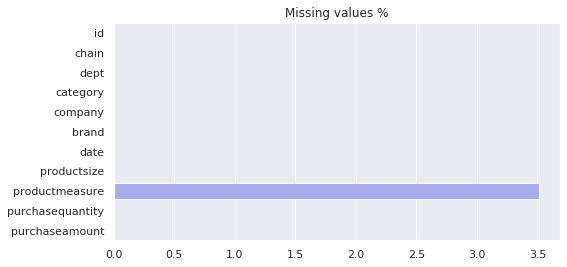

In [6]:
missing = df.isna().sum() / len(df) * 100
plt.figure(figsize=(8, 4))
_ = sns.barplot(y=missing.index, x=missing.values).set_title("Missing values %")

In [7]:
missing = df.isna().sum()
missing[missing > 0]

productmeasure    357640
dtype: int64

The only column with missing values is productmeasure which is also related to productsize == 0:

In [8]:
df.loc[df["productmeasure"].isna(), "productsize"].value_counts(dropna=False)

0.0    357640
Name: productsize, dtype: int64

In [9]:
df.loc[df["productsize"] <= 0, "productmeasure"].value_counts(dropna=False)

NaN    357640
OZ        254
Name: productmeasure, dtype: int64

Products with missing measure are mostly from category 0 (missing category) or 9609.

In [10]:
# Products with missing measure - % for each category (> 5%)
mask = df["productmeasure"].isna()
temp = df.loc[mask, "category"].value_counts(dropna=False, normalize=True)
temp[temp > 0.05]

0       0.521885
9609    0.461584
Name: category, dtype: float64

# 3. Univariate analysis

Univariate analysis with some aditional bivariate plots

### Purchase quantity and amount

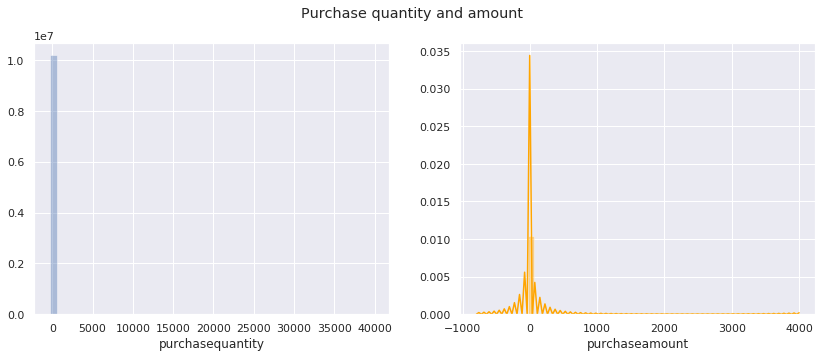

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Purchase quantity and amount')
sns.distplot(df.purchasequantity, ax=axes[0], kde=False)
_ = sns.distplot(df.purchaseamount, ax=axes[1], color="orange")

### Zero and negative values for purchase qty and amount

Exploring how negative values for quantity and amount are distributed within the data

Negative values percentage of the data
Quantity <= 0: 0.21%
Amount   <= 0: 4.12%


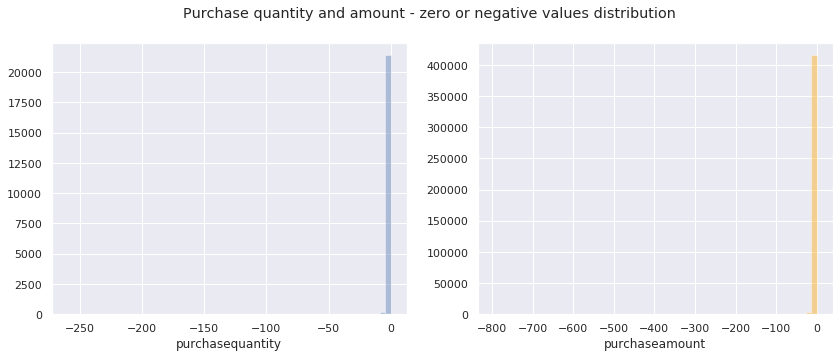

In [15]:
temp1 = df.loc[df.purchasequantity <= 0, "purchasequantity"]
temp2 = df.loc[df.purchaseamount <= 0, "purchaseamount"]
print("Negative values percentage of the data")
print("Quantity <= 0: {:.2f}%".format(100 * len(temp1)/len(df)))
print("Amount   <= 0: {:.2f}%".format(100 * len(temp2)/len(df)))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Purchase quantity and amount - zero or negative values distribution')
sns.distplot(temp1, ax=axes[0], kde=False, bins=60)
_ = sns.distplot(temp2, ax=axes[1], color="orange", kde=False, bins=60)

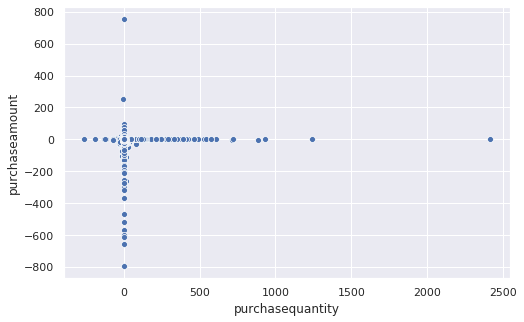

In [51]:
# Scatterplot with negative quantity or negative amount
temp = df.loc[(df.purchasequantity <= 0) | (df.purchaseamount <= 0)]
plt.figure(figsize=(8, 5))
_ = sns.scatterplot(x="purchasequantity", y="purchaseamount", data=temp)

In [20]:
# print percentages for different filters
mask = (df.purchasequantity <= 0) | (df.purchaseamount <= 0)
print("Qty <= 0 or amount <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))
mask = (df.purchasequantity <= 0) & (df.purchaseamount <= 0)
print("Qty <= 0 and amount <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))
mask = (df.purchasequantity > 0) & (df.purchaseamount <= 0)
print("Qty > 0 and amount <= 0: {:.2f}%".format(100 * len(df.loc[mask]) / len(df)))

Qty <= 0 or amount <= 0: 4.13%
Qty <= 0 and amount <= 0: 0.21%
Qty > 0 and amount <= 0: 3.92%


According to the data description, a negative value for quantity and amount indicates a return. However, when considering transactions with a negative quantity or amount, 95% of than have a positive quantity and negative amount.

Furthermore, transactions with positive quantity and negative amount represents almost 4% of our total sample. For the LTR model, we will be considering these negative amounts as product returns independent of the quantity value.

In [60]:
temp["category"].value_counts(normalize=True).head()

0       0.395269
9609    0.383739
9781    0.046311
9753    0.017392
907     0.005069
Name: category, dtype: float64

In [61]:
temp["brand"].value_counts(normalize=True).head()

88199    0.383739
0        0.360148
20405    0.052513
8255     0.046323
9907     0.008393
Name: brand, dtype: float64

Transactions with negative amount are also concentrated in a few departments/categories/brands.

### Store Chain

Number of unique values: 123


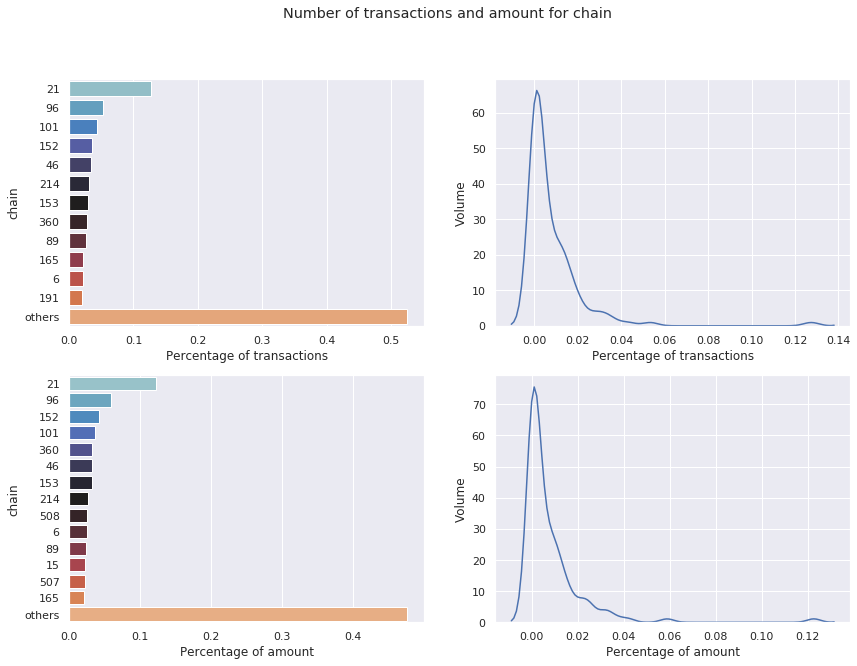

In [31]:
def categorical_analysis(column, group_threshold=0.02):
    cnt = df[column].value_counts(normalize=True)
    amt = df.groupby(column)["purchaseamount"].sum() / df["purchaseamount"].sum()
    amt.sort_values(ascending=False, inplace=True)
    print("Number of unique values:", len(cnt))

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()
    fig.suptitle('Number of transactions and amount for {}'.format(column))
    
    sns.distplot(cnt, hist=False, ax=axes[1])
    cnt["others"] = cnt[cnt < group_threshold].sum()
    cnt = cnt[cnt >= group_threshold]
    sns.barplot(y=cnt.index, x=cnt.values,
                ax=axes[0], palette="icefire")
    
    sns.distplot(amt, hist=False, ax=axes[3])
    amt["others"] = amt[amt < group_threshold].sum()
    amt = amt[amt >= group_threshold]
    sns.barplot(y=amt.index, x=amt.values,
                ax=axes[2], palette="icefire")

    _ = axes[0].set(xlabel='Percentage of transactions', ylabel=column)
    _ = axes[1].set(xlabel='Percentage of transactions', ylabel="Volume")
    _ = axes[2].set(xlabel='Percentage of amount', ylabel=column)
    _ = axes[3].set(xlabel='Percentage of amount', ylabel="Volume")


categorical_analysis("chain")

## Dept and Category

Number of unique values: 83


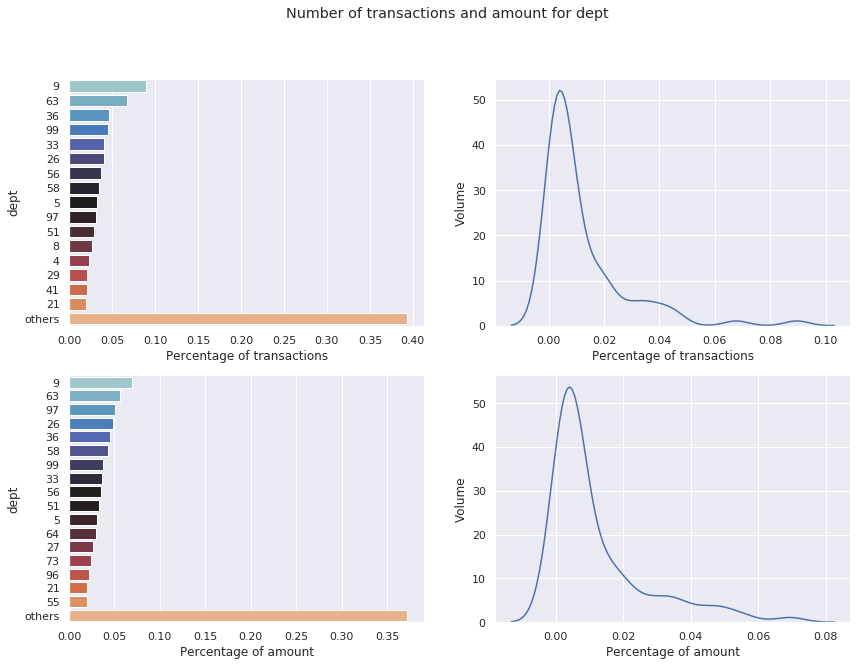

In [32]:
categorical_analysis("dept")

Number of unique values: 826


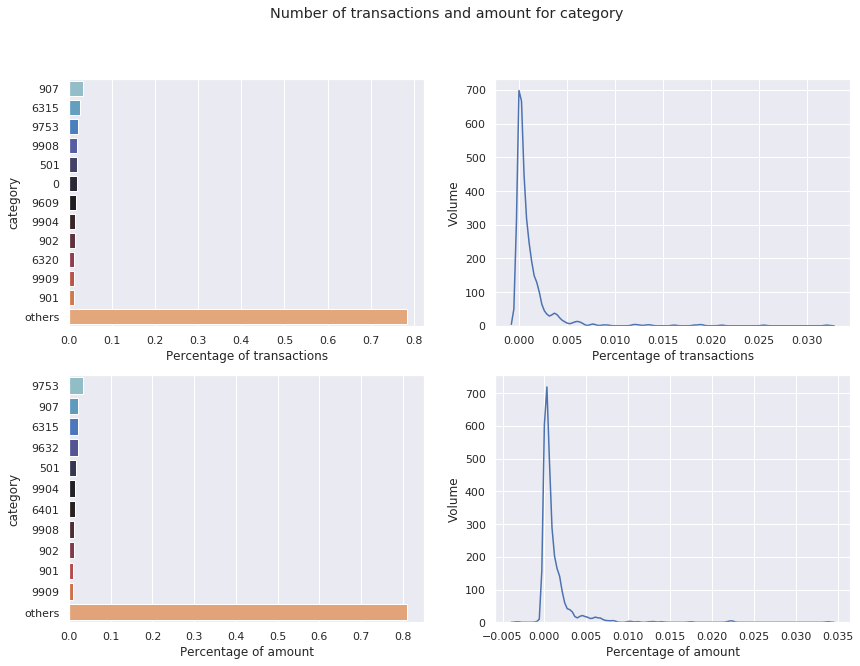

In [35]:
categorical_analysis("category", 0.01)

First two digits of the category indicates the dept, therefore the category numbers have a linear relationship:

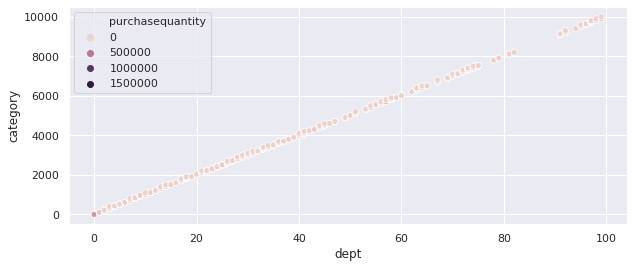

In [85]:
temp = df.groupby(["dept", "category"])["purchasequantity"].sum().to_frame()
temp.reset_index(inplace=True)
plt.figure(figsize=(10, 4))
_ = sns.scatterplot(x="dept", y="category", hue="purchasequantity", data=temp)

In [86]:
temp[:12]

,dept,category,purchasequantity
0,0,0,329492
1,1,103,6063
2,1,104,2885
3,1,105,5837
4,1,106,72974
5,2,201,26273
6,2,202,20908
7,2,203,154
8,2,207,239
9,2,208,1424


### Brand and Company

Number of unique values: 19188


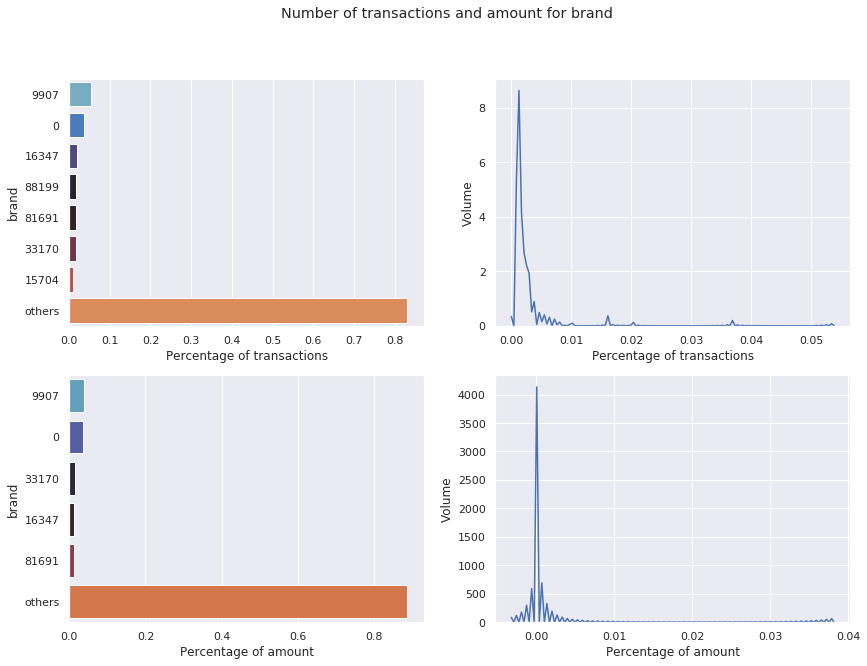

In [39]:
categorical_analysis("brand", 0.01)

Number of unique values: 19057


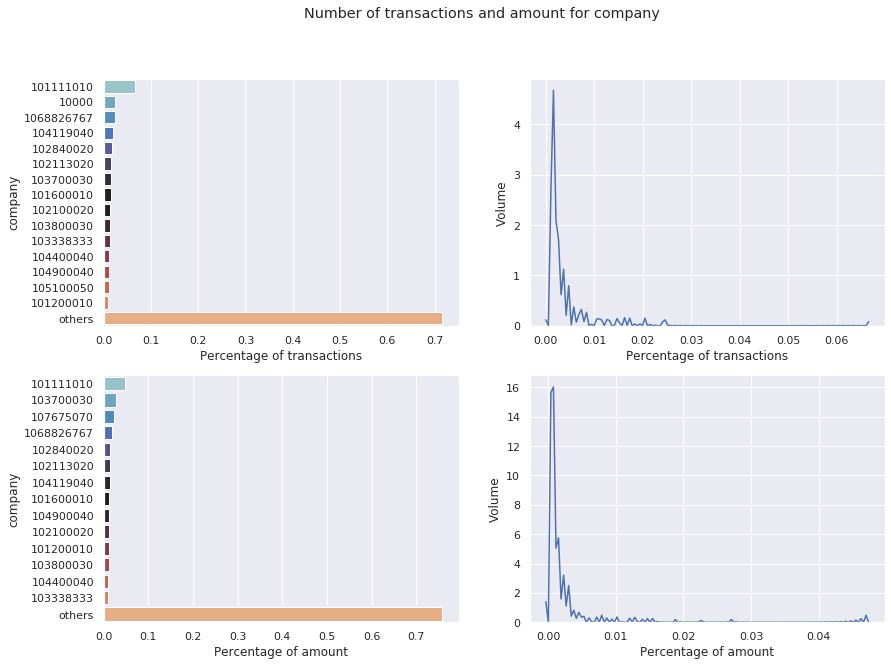

In [40]:
categorical_analysis("company", 0.01)

# 4. Timeseries analysis

Checking transactions over time

In [98]:
print("Initial date:", df.date.min(), "- last date:", df.date.max())

Initial date: 20120302 - last date: 20130728


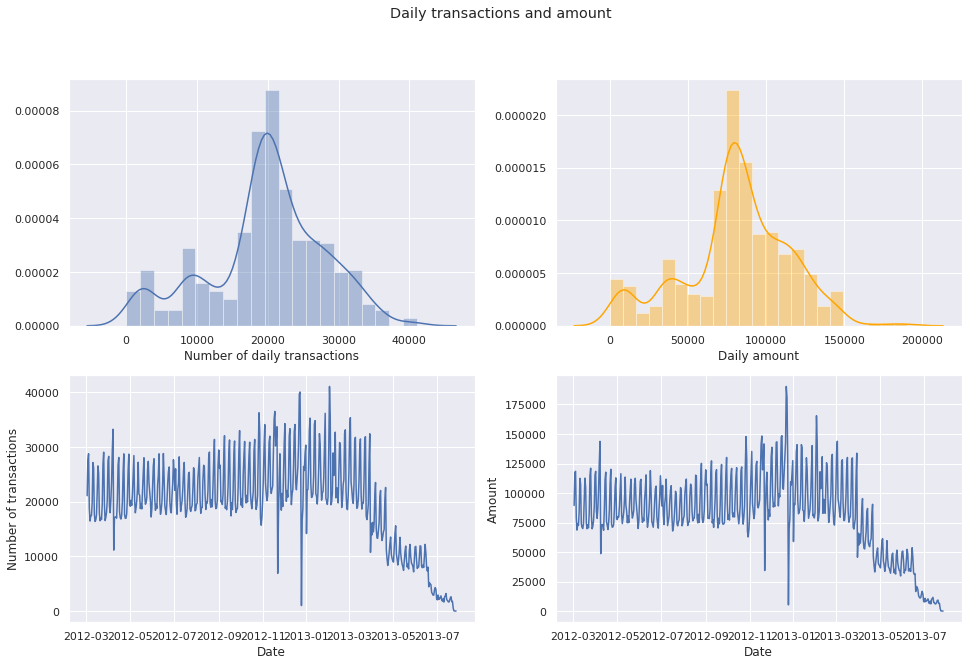

In [125]:
df["date_time"] = pd.to_datetime(df.date.astype(str), infer_datetime_format=True)
dc = df.groupby("date_time")["purchaseamount"].count()
ds = df.groupby("date_time")["purchaseamount"].sum()

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
fig.suptitle('Daily transactions and amount')
sns.distplot(dc, ax=axes[0])
sns.distplot(ds, ax=axes[1], color="orange")
sns.lineplot(x=dc.index, y=dc.values, ax=axes[2])
sns.lineplot(x=ds.index, y=ds.values, ax=axes[3])

_ = axes[0].set(xlabel='Number of daily transactions')
_ = axes[1].set(xlabel='Daily amount')
_ = axes[2].set(xlabel='Date', ylabel='Number of transactions')
_ = axes[3].set(xlabel='Date', ylabel='Amount')

There is a sharp decline in sales after march 2013 without any explanation. This is probabibly due to the data collection process. To keep the dataset consistent we will need to cut the last few months.

### Seasonality and special dates

Besides that, we can see special dates like Christmas and Thanksgiving:

In [126]:
# bottom five dates for purchase amount
ds[ds.index < datetime(2013, 3, 31)].sort_values()[:5]

date_time
2012-12-25     5249.319824
2012-11-22    34331.769531
2012-04-08    48614.320312
2013-01-01    58921.328125
2012-10-30    62793.238281
Name: purchaseamount, dtype: float32

In [127]:
# top five dates for purchase amount
ds[ds.index < datetime(2013, 3, 31)].sort_values(ascending=False)[:5]

date_time
2012-12-22    190292.750000
2012-12-23    180796.734375
2013-02-02    165502.906250
2012-12-16    148562.453125
2012-11-18    148273.093750
Name: purchaseamount, dtype: float32

#### And also some weekly seasonality:

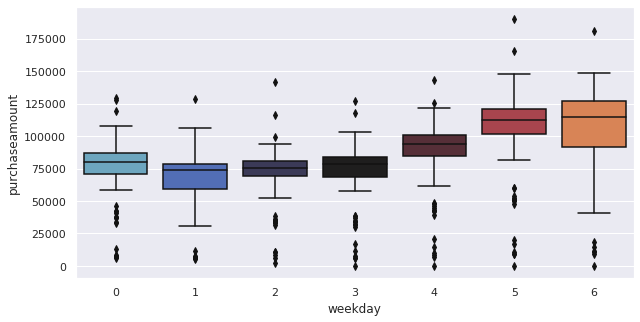

In [139]:
ds = ds.to_frame().reset_index()
ds["weekday"] = ds["date_time"].dt.weekday
plt.figure(figsize=(10, 5))
_ = sns.boxplot(x="weekday", y="purchaseamount", data=ds, palette="icefire")

# 5. Customer-aggregated analysis

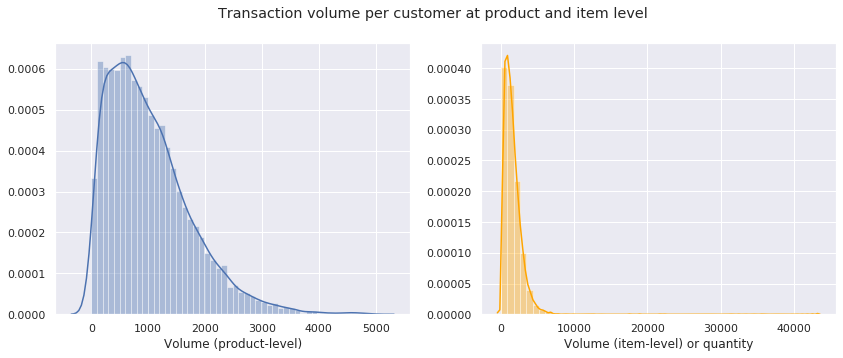

In [30]:
prod_transactions = df.groupby("id")["purchasequantity"].count()
item_transactions = df.groupby("id")["purchasequantity"].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Transaction volume per customer at product and item level')
sns.distplot(prod_transactions, ax=axes[0])
sns.distplot(item_transactions, ax=axes[1], color="orange")
_ = axes[0].set(xlabel='Volume (product-level)')
_ = axes[1].set(xlabel='Volume (item-level) or quantity')

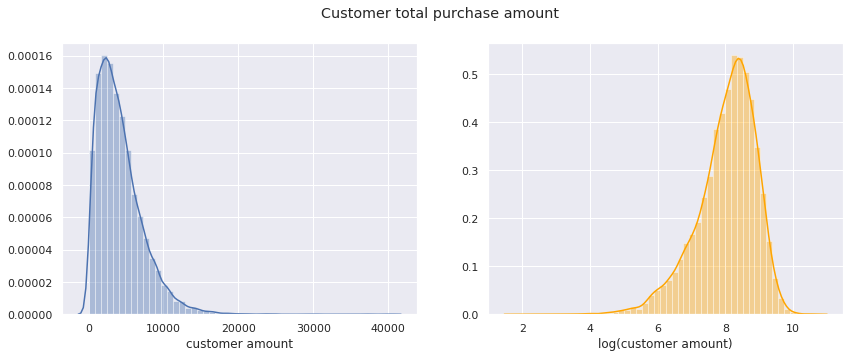

In [141]:
customer_amount = df.groupby("id")["purchaseamount"].sum()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Customer total purchase amount')
sns.distplot(customer_amount, ax=axes[0])
sns.distplot(np.log(customer_amount), ax=axes[1], color="orange")
_ = axes[0].set(xlabel='customer amount')
_ = axes[1].set(xlabel='log(customer amount)')

#### How many chains does a customer visit?

In [144]:
num_chains = df.groupby("id")["chain"].nunique()
num_chains.value_counts(normalize=True)

1    10000
Name: chain, dtype: int64

It seems like each customer uses a single store chain

#### How many departments?

In [149]:
num_dept = df.groupby("id")["dept"].nunique()
num_dept.value_counts(normalize=True)[:5]

64    0.0428
65    0.0418
63    0.0417
67    0.0416
66    0.0396
Name: dept, dtype: float64